In [1]:
import control
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn

In [2]:
from net_identification_utils import train,\
    plot_discrete_output,\
    generate_data,\
    generate_data_for_input_output_rnn_training,\
    ControlLSTMInputsOutputs,\
    hyper_search

In [3]:
system = control.TransferFunction(np.array([1, 0]), np.array([1, -7/12, 1/4, -1/24]), 1)

In [4]:
train_dataset = generate_data_for_input_output_rnn_training(
    control_sys=system,
    impact_time=1000,
    n_signals=100,
    n_samples_per_signal=20,
    sample_u_size=100,
    layer_input_size=20,
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [5]:
model = ControlLSTMInputsOutputs(window_size=100, layer_input_size=20, hidden_size=50, output_size=20, num_layers=2)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [7]:
train(model, 100, train_dataloader, nn.MSELoss())

epoch 0, mse 0.07761482566245831
epoch 1, mse 0.005676179687434342
epoch 2, mse 0.0012647475519042928
epoch 3, mse 0.000462198871318833
epoch 4, mse 0.00035417115843301873
epoch 5, mse 0.00028265437056688823
epoch 6, mse 0.0002779519930300012
epoch 7, mse 0.0003134615251474315
epoch 8, mse 0.00021861217872356064
epoch 9, mse 0.00022295346567261732
epoch 10, mse 0.00022615557323661052
epoch 11, mse 0.00019844325723170187
epoch 12, mse 0.00018107708141542388
epoch 13, mse 0.00019759073331442777
epoch 14, mse 0.00019963132028351537
epoch 15, mse 0.00014818679644122313
epoch 16, mse 0.00022913866783710546
epoch 17, mse 0.00012930141212564195
epoch 18, mse 0.00015714476525317876
epoch 19, mse 0.0001943125391153444
epoch 20, mse 0.0001589520668494515
epoch 21, mse 0.00013880239146601525
epoch 22, mse 0.00016611750636002397
epoch 23, mse 0.00012490418421293726
epoch 24, mse 0.00013504196152098303
epoch 25, mse 0.00017040233175066532
epoch 26, mse 0.00012015121968943276
epoch 27, mse 0.0001318

In [20]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=180,
    cooldown_time=0,
    n_signals=1000,
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [21]:
model.test(test_dataset, nn.MSELoss(), batch_size=1)

1.3482839686730585e-05

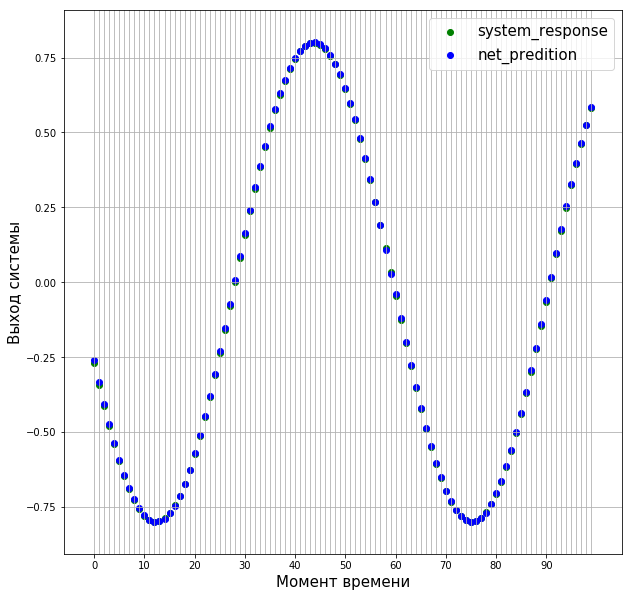

In [22]:
u = np.sin(np.arange(1000) * 0.1) / 2
response = control.forced_response(system, T=np.arange(1000), U=u)[1][0]
prediction = model.predict(torch.tensor(u, requires_grad=True).float())
plot_discrete_output(
    system_response=response[100:200],
    net_predition=prediction[0, 100:200],
    # file_name='reports/rnn_2_prediction.png'
)

### shifted frequencies

In [13]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=180,
    cooldown_time=0,
    n_signals=1000,
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.1, high=0.2)) / 2
)

In [24]:
model.test(test_dataset, nn.MSELoss())

0.012449543755501509

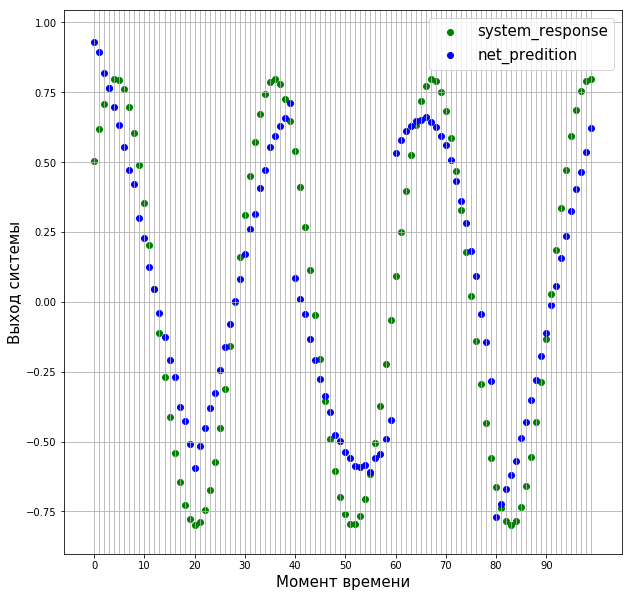

In [33]:
u = np.sin(np.arange(1000) * 0.2) / 2
response = control.forced_response(system, T=np.arange(1000), U=u)[1][0]
prediction = model.predict(torch.tensor(u, requires_grad=True).float())
plot_discrete_output(
    system_response=response[100:200],
    net_predition=prediction[0, 100:200],
    # file_name='reports/rnn_2_prediction_shifted_0_2.png'
)

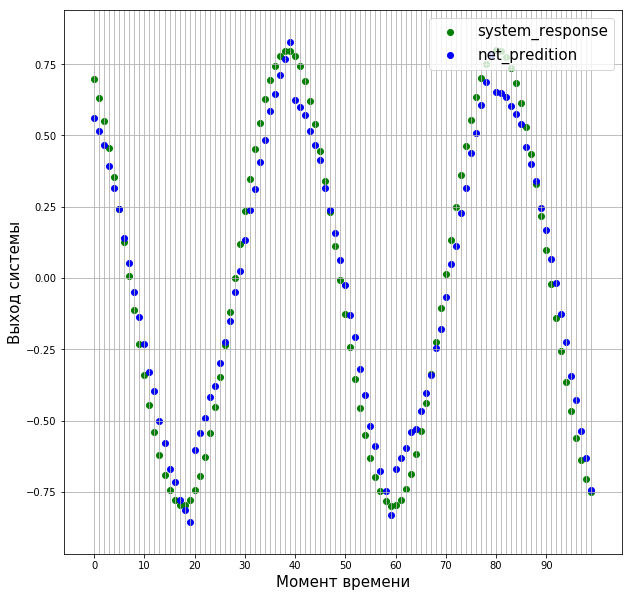

In [34]:
u = np.sin(np.arange(1000) * 0.15) / 2
response = control.forced_response(system, T=np.arange(1000), U=u)[1][0]
prediction = model.predict(torch.tensor(u, requires_grad=True).float())
plot_discrete_output(
    system_response=response[100:200],
    net_predition=prediction[0, 100:200],
    # file_name='reports/rnn_2_prediction_shifted_0_15.png'
)

### mixed signals as input

In [8]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=180,
    cooldown_time=0,
    n_signals=1000,
    u_signal_generation_func=lambda x:
    (   # random mixture of two sinus with different frequencies
        np.sin(np.arange(x) * np.random.uniform(low=0.1, high=0.2)) + 
        np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1))
    ) / 4
)

In [9]:
model.test(test_dataset, nn.MSELoss())

0.0014647390705067665

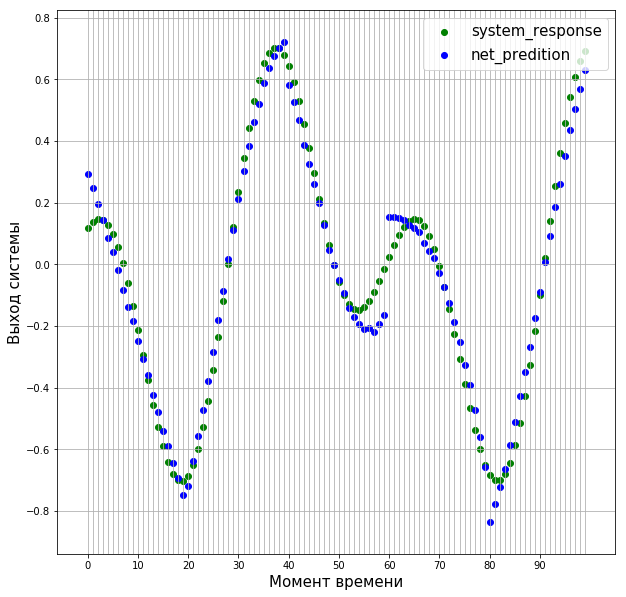

In [10]:
u = (np.sin(np.arange(1000) * 0.2) + np.sin(np.arange(1000) * 0.1)) / 4
response = control.forced_response(system, T=np.arange(1000), U=u)[1][0]
prediction = model.predict(torch.tensor(u, requires_grad=True).float())
plot_discrete_output(
    system_response=response[100:200],
    net_predition=prediction[0, 100:200],
    file_name='reports/rnn_2_prediction_mix_0_1_0_2.png'
)

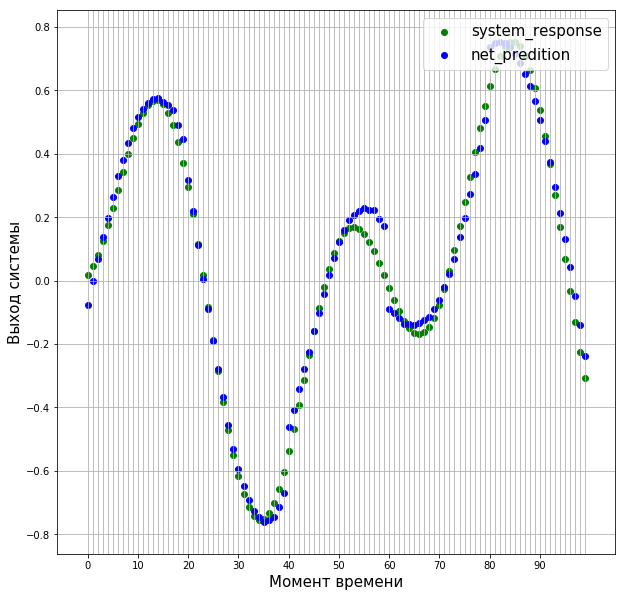

In [11]:
u = (np.sin(np.arange(1000) * 0.18) + np.sin(np.arange(1000) * 0.08)) / 4
response = control.forced_response(system, T=np.arange(1000), U=u)[1][0]
prediction = model.predict(torch.tensor(u, requires_grad=True).float())
plot_discrete_output(
    system_response=response[100:200],
    net_predition=prediction[0, 100:200],
    # file_name='reports/rnn_2_prediction_mix_0_08_0_18.png'
)

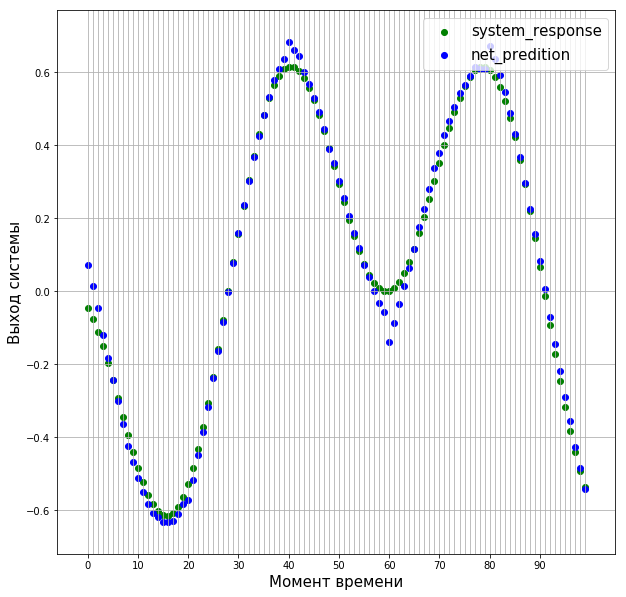

In [12]:
u = (np.sin(np.arange(1000) * 0.15) + np.sin(np.arange(1000) * 0.05)) / 4
response = control.forced_response(system, T=np.arange(1000), U=u)[1][0]
prediction = model.predict(torch.tensor(u, requires_grad=True).float())
plot_discrete_output(
    system_response=response[100:200],
    net_predition=prediction[0, 100:200],
    # file_name='reports/rnn_2_prediction_mix_0_05_0_15.png'
)

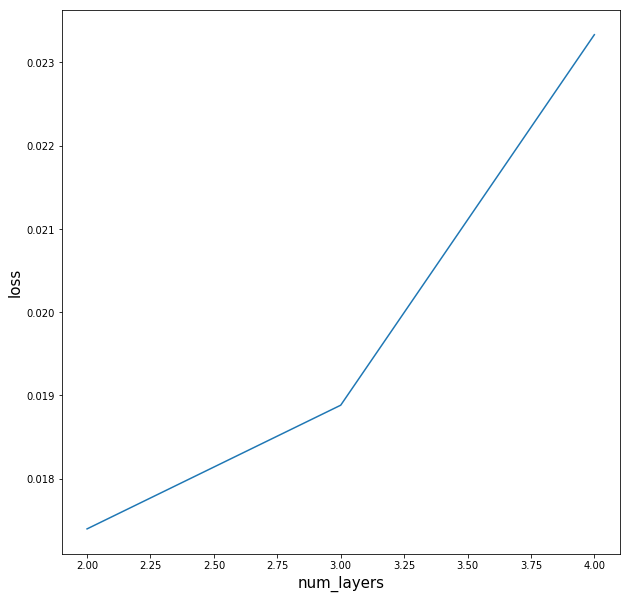

In [14]:
hyper_search(
    model_class=ControlLSTMInputsOutputs,
    train_dataloader=train_dataloader,
    test_dataset=test_dataset,
    default_init_args={
        'window_size': 100,
        'layer_input_size': 20,
        'hidden_size': 50,
        'output_size': 20,
        'num_layers': 2
    },
    arg_variants={'num_layers': list(map(int, np.arange(2, 5)))},
    train_epochs=50,
    test_func='buildin',
    plot_file_name='lstm_2_num_layers_search.png'
)

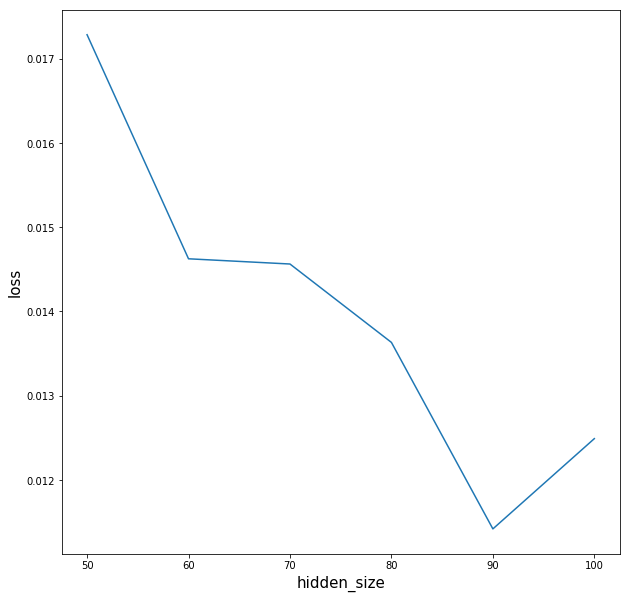

In [15]:
hyper_search(
    model_class=ControlLSTMInputsOutputs,
    train_dataloader=train_dataloader,
    test_dataset=test_dataset,
    default_init_args={
        'window_size': 100,
        'layer_input_size': 20,
        'hidden_size': 50,
        'output_size': 20,
        'num_layers': 2
    },
    arg_variants={'hidden_size': list(map(int, np.arange(5, 11) * 10))},
    train_epochs=50,
    test_func='buildin',
    plot_file_name='lstm_2_hidden_size_search.png'
)